<a href="https://colab.research.google.com/github/biffsocko/SUNY_Poly_NCS590/blob/main/ddos_attack_detection_Tom_Murphy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Tom Murphy</h2>

202301-NCS-590-3407: Spring 2023

DDoS Attack Detection Classification:<br>
data set details can be found here: https://data.mendeley.com/datasets/jxpfjc64kr/1

results of the DDOS attack are in column "label" - as a boolene value 0 or 1

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
from sklearn import metrics
from sklearn import metrics

Read in the data set

In [2]:
#data = pd.read_csv('/content/dataset_sdn.csv')
data = pd.read_csv(filepath_or_buffer="http://drop.biffsocko.com/dataset_sdn.csv", sep=',')
#shuffle
#data = data.sample(frac=1)

show the first few rows

In [3]:
data.head()

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,...,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,...,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,3,3413,3665,0,0.0,0.0,0


describe the data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104345 entries, 0 to 104344
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt           104345 non-null  int64  
 1   switch       104345 non-null  int64  
 2   src          104345 non-null  object 
 3   dst          104345 non-null  object 
 4   pktcount     104345 non-null  int64  
 5   bytecount    104345 non-null  int64  
 6   dur          104345 non-null  int64  
 7   dur_nsec     104345 non-null  int64  
 8   tot_dur      104345 non-null  float64
 9   flows        104345 non-null  int64  
 10  packetins    104345 non-null  int64  
 11  pktperflow   104345 non-null  int64  
 12  byteperflow  104345 non-null  int64  
 13  pktrate      104345 non-null  int64  
 14  Pairflow     104345 non-null  int64  
 15  Protocol     104345 non-null  object 
 16  port_no      104345 non-null  int64  
 17  tx_bytes     104345 non-null  int64  
 18  rx_bytes     104345 non-

Below shows the number of DDOS attacks vs. Non-attacks (legit traffic)

In [5]:
data.label.value_counts()

0    63561
1    40784
Name: label, dtype: int64

Check for NULL values

In [6]:
data.isnull().sum()

dt               0
switch           0
src              0
dst              0
pktcount         0
bytecount        0
dur              0
dur_nsec         0
tot_dur          0
flows            0
packetins        0
pktperflow       0
byteperflow      0
pktrate          0
Pairflow         0
Protocol         0
port_no          0
tx_bytes         0
rx_bytes         0
tx_kbps          0
rx_kbps        506
tot_kbps       506
label            0
dtype: int64

In [7]:
# Replace nulls with zeros
data.fillna(0, inplace=True)

now check again for NULL values

In [8]:
data.isnull().sum()

dt             0
switch         0
src            0
dst            0
pktcount       0
bytecount      0
dur            0
dur_nsec       0
tot_dur        0
flows          0
packetins      0
pktperflow     0
byteperflow    0
pktrate        0
Pairflow       0
Protocol       0
port_no        0
tx_bytes       0
rx_bytes       0
tx_kbps        0
rx_kbps        0
tot_kbps       0
label          0
dtype: int64

check for duplicate data

In [40]:
duplicates = data.duplicated()
duplicate_rows = duplicates.sum()
# Print the results
print("Number of duplicate rows:", duplicate_rows)

Number of duplicate rows: 5091


remove the duplicate rows

In [42]:
# Remove duplicate rows
data.drop_duplicates(inplace=True)

show that the duplicate rows were removed

In [43]:
duplicates = data.duplicated()
duplicate_rows = duplicates.sum()
# Print the results
print("Number of duplicate rows:", duplicate_rows)

Number of duplicate rows: 0


show highly correlated colmns

In [44]:
corr_matrix = data.corr()

threshold = 0.99
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

for corr in high_corr:
    print(f"{corr[0]} and {corr[1]}: {corr[2]}")

tot_dur and dur: 0.9999983911151613
pktrate and pktperflow: 0.9999988531120457


<ipython-input-44-75ddcc456641>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


In [45]:
#delete high correlation data
data.drop('pktrate', axis=1, inplace=True)
data.drop('tot_dur', axis=1, inplace=True)

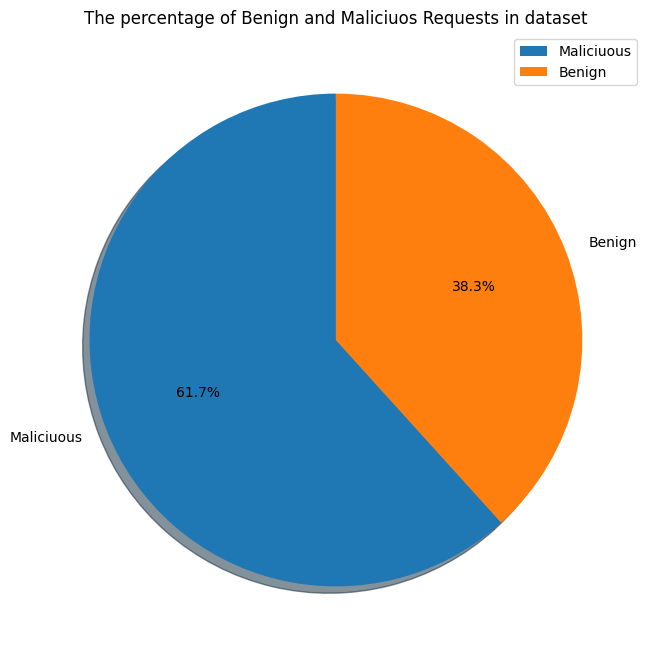

In [46]:
labels = ["Maliciuous",'Benign']
sizes = [dict(data.label.value_counts())[0], dict(data.label.value_counts())[1]]
plt.figure(figsize = (13,8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.legend(["Maliciuous", "Benign"])
plt.title('The percentage of Benign and Maliciuos Requests in dataset')
plt.show()

find colunms that are not numeric

In [47]:
#### Let's  find out object columns

object_df = data.select_dtypes(include=['object'])
object_cols = object_df.columns
print('Object Columns: ')
print(object_cols, '\n')
print('Number of Object Features: ', len(object_cols))

Object Columns: 
Index(['src', 'dst', 'Protocol'], dtype='object') 

Number of Object Features:  3


show sample of object columns

In [48]:
object_df.head()

,src,dst,Protocol
0,10.0.0.1,10.0.0.8,UDP
1,10.0.0.1,10.0.0.8,UDP
2,10.0.0.2,10.0.0.8,UDP
3,10.0.0.2,10.0.0.8,UDP
4,10.0.0.2,10.0.0.8,UDP


show unique data in the object colunms

In [49]:
print(sorted(data['Protocol'].unique()))
print(data['Protocol'].nunique())
print(sorted(data['src'].unique()))
print("Sources: ", data['src'].nunique())
print(sorted(data['dst'].unique()))
print("Destinations: ",data['dst'].nunique())

['ICMP', 'TCP', 'UDP']
3
['10.0.0.1', '10.0.0.10', '10.0.0.11', '10.0.0.12', '10.0.0.13', '10.0.0.14', '10.0.0.15', '10.0.0.16', '10.0.0.17', '10.0.0.18', '10.0.0.2', '10.0.0.20', '10.0.0.3', '10.0.0.4', '10.0.0.5', '10.0.0.6', '10.0.0.7', '10.0.0.8', '10.0.0.9']
Sources:  19
['10.0.0.1', '10.0.0.10', '10.0.0.11', '10.0.0.12', '10.0.0.13', '10.0.0.14', '10.0.0.15', '10.0.0.16', '10.0.0.17', '10.0.0.18', '10.0.0.2', '10.0.0.3', '10.0.0.4', '10.0.0.5', '10.0.0.6', '10.0.0.7', '10.0.0.8', '10.0.0.9']
Destinations:  18


convert the string values to numeric

In [50]:
# convert string values to numeric 
le=preprocessing.LabelEncoder()
clm=['Protocol', 'src', 'dst']
for x in clm:
    data[x]=le.fit_transform(data[x])

show the columns again

In [51]:
print(sorted(data['Protocol'].unique()))
print(data['Protocol'].nunique())
print(sorted(data['src'].unique()))
print("Sources: ", data['src'].nunique())
print(sorted(data['dst'].unique()))
print("Destinations: ",data['dst'].nunique())

[0, 1, 2]
3
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Sources:  19
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Destinations:  18


show that there is no more object data

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99254 entries, 0 to 104344
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dt           99254 non-null  int64  
 1   switch       99254 non-null  int64  
 2   src          99254 non-null  int64  
 3   dst          99254 non-null  int64  
 4   pktcount     99254 non-null  int64  
 5   bytecount    99254 non-null  int64  
 6   dur          99254 non-null  int64  
 7   dur_nsec     99254 non-null  int64  
 8   flows        99254 non-null  int64  
 9   packetins    99254 non-null  int64  
 10  pktperflow   99254 non-null  int64  
 11  byteperflow  99254 non-null  int64  
 12  Pairflow     99254 non-null  int64  
 13  Protocol     99254 non-null  int64  
 14  port_no      99254 non-null  int64  
 15  tx_bytes     99254 non-null  int64  
 16  rx_bytes     99254 non-null  int64  
 17  tx_kbps      99254 non-null  int64  
 18  rx_kbps      99254 non-null  float64
 19  tot

split that data set into 20% training data and 80% testing data

In [54]:
# Split the dataset into training and test sets
df_train, df_test = train_test_split(data, test_size=0.2)

# Print the sizes of the training and test sets
print('Training set size:', len(df_train))
print('Test set size:', len(df_test))

Training set size: 79403
Test set size: 19851


remove colunm "label" with the output answer

In [55]:
df_train.head(5)

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,flows,packetins,...,byteperflow,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
100410,6672,6,18,3,753,73794,771,715000000,7,3443,...,2842,0,0,3,134894848,10815,0,0.0,0.0,0
93267,30681,7,4,1,92490,96374580,331,62000000,11,4920,...,8935150,1,0,2,53659,49080,0,0.0,0.0,1
71108,7297,7,6,15,93799,5065146,317,287000000,5,12106,...,454788,1,1,3,12144745,10992806,259,241.0,500.0,1
6154,11485,3,4,16,65897,68664674,210,876000000,5,1943,...,9677054,0,2,4,450717295,4589,12817,0.0,12817.0,1
78314,42455,3,7,13,242987,13121298,440,743000000,5,13231,...,932202,1,1,3,174300759,174474652,0,128.0,128.0,1


In [57]:
x_train=df_train.drop('label',axis=1)
x_train.head(5)


,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,flows,packetins,pktperflow,byteperflow,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps
100410,6672,6,18,3,753,73794,771,715000000,7,3443,29,2842,0,0,3,134894848,10815,0,0.0,0.0
93267,30681,7,4,1,92490,96374580,331,62000000,11,4920,8575,8935150,1,0,2,53659,49080,0,0.0,0.0
71108,7297,7,6,15,93799,5065146,317,287000000,5,12106,8422,454788,1,1,3,12144745,10992806,259,241.0,500.0
6154,11485,3,4,16,65897,68664674,210,876000000,5,1943,9287,9677054,0,2,4,450717295,4589,12817,0.0,12817.0
78314,42455,3,7,13,242987,13121298,440,743000000,5,13231,17263,932202,1,1,3,174300759,174474652,0,128.0,128.0


In [58]:
y_train=df_train["label"]
y_train.head(5)


100410    0
93267     1
71108     1
6154      1
78314     1
Name: label, dtype: int64

In [59]:
df_test.head(5)

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,flows,packetins,...,byteperflow,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
31510,3609,7,12,13,119493,124511706,407,535000000,2,7916,...,7366940,0,2,2,4575,1382,0,0.0,0.0,1
25417,3429,3,12,13,70034,72975428,226,384000000,5,7916,...,9220658,0,2,3,4542,217287734,0,2493.0,2493.0,1
77016,42035,6,7,13,8280,447120,21,284000000,5,12549,...,0,1,1,2,3322752,84224372,159,4003.0,4162.0,1
95479,5502,5,14,3,49516,51595672,168,311000000,4,1264,...,9141466,1,0,2,4546,1402,0,0.0,0.0,1
53788,32493,2,2,11,86,8428,88,465000000,7,20,...,2940,1,0,1,30190,27338,2,2.0,4.0,0


In [60]:
x_test=df_test.drop('label',axis=1)
x_test.head(5)


,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,flows,packetins,pktperflow,byteperflow,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps
31510,3609,7,12,13,119493,124511706,407,535000000,2,7916,7070,7366940,0,2,2,4575,1382,0,0.0,0.0
25417,3429,3,12,13,70034,72975428,226,384000000,5,7916,8849,9220658,0,2,3,4542,217287734,0,2493.0,2493.0
77016,42035,6,7,13,8280,447120,21,284000000,5,12549,0,0,1,1,2,3322752,84224372,159,4003.0,4162.0
95479,5502,5,14,3,49516,51595672,168,311000000,4,1264,8773,9141466,1,0,2,4546,1402,0,0.0,0.0
53788,32493,2,2,11,86,8428,88,465000000,7,20,30,2940,1,0,1,30190,27338,2,2.0,4.0


In [61]:
y_test=df_test["label"]
y_test.head(5)

31510    1
25417    1
77016    1
95479    1
53788    0
Name: label, dtype: int64

<h1>show different results based on model:</h1>

In [62]:
lr = LogisticRegression(max_iter=1000, solver='lbfgs')
lr.fit(x_train, y_train)
# Make predictions
predictions = lr.predict(x_test)
confusion = confusion_matrix(y_test,predictions)
tn, fp, fn, tp = confusion.ravel()
print("True Positive: ", tp)
print("False Positive: ", fp)
print("True Negative: ", tn)
print("False Negative: ", fn)
accuracy = round(accuracy_score(predictions, y_test)*100,2)
print("Accuracy", accuracy)

True Positive:  4221
False Positive:  2019
True Negative:  10181
False Negative:  3430
Accuracy 72.55


In [63]:
dt = DecisionTreeClassifier(max_depth=20)
dt.fit(x_train, y_train)
# Make predictions
predictions = dt.predict(x_test)
confusion = confusion_matrix(y_test,predictions)
tn, fp, fn, tp = confusion.ravel()
print("True Positive: ", tp)
print("False Positive: ", fp)
print("True Negative: ", tn)
print("False Negative: ", fn)
accuracy = round(accuracy_score(predictions, y_test)*100,2)
print("Accuracy", accuracy)

True Positive:  7648
False Positive:  0
True Negative:  12200
False Negative:  3
Accuracy 99.98


In [67]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(x_train, y_train)
predictions = neigh.predict(x_test)
confusion = confusion_matrix(y_test,predictions)
tn, fp, fn, tp = confusion.ravel()
print("True Positive: ", tp)
print("False Positive: ", fp)
print("True Negative: ", tn)
print("False Negative: ", fn)
accuracy = round(accuracy_score(predictions, y_test)*100,2)
print("Accuracy", accuracy)


True Positive:  6395
False Positive:  1202
True Negative:  10998
False Negative:  1256
Accuracy 87.62


In [65]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
confusion = confusion_matrix(y_test,predictions)
tn, fp, fn, tp = confusion.ravel()
print("True Positive: ", tp)
print("False Positive: ", fp)
print("True Negative: ", tn)
print("False Negative: ", fn)
accuracy = round(accuracy_score(predictions, y_test)*100,2)
print("Accuracy", accuracy)


True Positive:  7651
False Positive:  0
True Negative:  12200
False Negative:  0
Accuracy 100.0
